### Introduction

This notebook is my excercise with to purposes: learn Cirq and learn quantum error correction.

It is based on material in Chapter 10 of "Quantum Computation and Quantum Informaton" by Nielsen and Chuang.

**Warning.** Cells with charts will take long time to run.

### The problem

Suppose we have noisy quantum channel, which with probability $p$ changes transmitted qubit in a certain way. We have qubit and we want to pass it through this channel. We can use perfect (not-faulty) gates. We are allowed to encode given qubit into several qubits. Each of them is transmitted throw noisy channel. Then we can decode resulting qubit and we have to present one qubit. State of this qubit should be exactly the same as state of qubit we started with.

For beginning, noisy channel will apply bit-flip (i.e. X gate) with probability p, later we will consider other types of noise.

### The framework

There is qubit $| \psi >$. We allowed to "encode" it, by applying certain cirquit which produces one or more qubits.
Then these qubits are passed (independently) throw faulty channel. Then we allowed to "decode" result by applying another circuit to received cubits. It should producr one qubit. Finally, we check whether this is the same qubit as the one we started with. We repeat this many times with different (random) $| \psi >$ and measure error rate $p_1$. We will change $p_0$ and see how $p_1$ changes.

Let's build this framework and test it with no encoding-decoding. Obviosly, we expect $p_1=p_0$.


**How do we generate initial state?**

Any qubit state corresponds to a point on Bloch sphere. Let's generate random $\theta \in [0, \pi]$ and $\phi \in [0, 2 \pi]$. Then state is $ | \psi\rangle= \cos(\theta/2) |0 \rangle + e^{i \phi} \sin(\theta/2) |1 \rangle$. To get it from 
$| 0 \rangle$, apply gate defined by unitary matrix:

$$\begin{pmatrix}
   \cos(\frac{\theta}{2}) & -\sin(\frac{\theta}{2}) \\
   e^{i \phi} \sin(\frac{\theta}{2}) & e^{i \phi} \cos(\frac{\theta}{2})
  \end{pmatrix} $$
  
Cartesian coordinates of this state on the bloch sphere are $(\sin(\theta) \cos(\phi), \sin(\theta) \sin(\phi), \cos(\theta))$.

In [82]:
import numpy as np
from matplotlib import pyplot as plt
import cirq

class BaseQecProtocol:
    def __init__(self):
        self.name = 'No encoding'
    
    def encode(self, circuit, qubit):
        return [qubit]
    
    def decode(self, circuit, qubits):
        return qubits[0]

class BitFlipChannel:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob
        
    def transmit(self, ct, q):
        if np.random.rand() < self.flip_prob:
            ct.append(cirq.X(q))
        return q

# Transmits random qubit using given channel and protocol and returns if transmission was successful.
# If output is passed, writes there circuit.
def test_protocol_once(protocol, channel, output=None):
    # Generate qubit (in Bloch sphere notation).
    theta = np.random.rand() * np.pi
    phi = np.random.rand() * 2*np.pi

    # Coordinates on Bloch sphere (for asserion in the end of experiment).
    init_bloch_coords = np.array([np.sin(theta)*np.cos(phi), 
                                  np.sin(theta)*np.sin(phi), 
                                  np.cos(theta)])

    # Create cirquit with one qubit and initialize it to generated state.
    ct = cirq.Circuit()
    q_init = cirq.NamedQubit('q_init')
    U0 = np.array([[np.cos(0.5 * theta), -np.sin(0.5*theta)], 
                  [np.exp(1j * phi) * np.sin(0.5 * theta), np.exp(1j*phi) * np.cos(0.5*theta)]])
    ct.append(cirq.SingleQubitMatrixGate(U0).on(q_init))

    # Encode.
    encoded_qubits = protocol.encode(ct, q_init)

    # Transmit.
    transmitted_qubits = [channel.transmit(ct, q) for q in encoded_qubits]

    # Decode.
    decoded_qubit = protocol.decode(ct, transmitted_qubits)

    # Simulate cirquit to get final state of decoded qubit.
    sim = cirq.Simulator()
    sim.simulate(ct)
    result = sim.simulate(ct)
    result_bloch_coords = result.bloch_vector_of(decoded_qubit)
    
    # Protocol should ensurre that decoded_qubit is not entangled with other qubits.
    if not np.allclose(np.linalg.norm(result_bloch_coords), 1.0):
        raise ValueError("Not pure state %s" % result_bloch_coords)
        
    if output != None:
        output['circuit'] = ct

    # Return whether qubit state was correctly transmitted.
    return np.linalg.norm(result_bloch_coords - init_bloch_coords) < 1e-5

# Experimentally calculates failure rate of error correcting protocol.
def test_protocol(protocol, channel, num_experiments=100):
    ok_count = sum([test_protocol_once(protocol, channel) for _ in range(num_experiments)])
    return 1.0 - 1.0 * ok_count  / num_experiments
          
def plot_errors(protocol, 
                num_points=21, 
                num_experiments=100, 
                theoretical=None,
                channel_factory=lambda p:BitFlipChannel(p),
                max_p=1.0):
    channel_error = np.linspace(0, max_p, num_points)
    protocol_error = [test_protocol(protocol, channel_factory(p), num_experiments=num_experiments)
                      for p in channel_error]
    plt.plot(channel_error, protocol_error, label='Experiment')
    plt.xlabel('Channel error')
    plt.ylabel('Protocol error')
    plt.title(protocol.name)
    
    if not theoretical is None:
        plt.plot(channel_error, theoretical(channel_error), '--', label='Theory')
    plt.legend()
    plt.grid()
    plt.show()

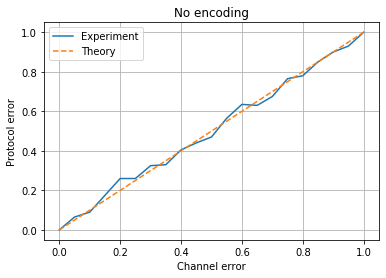

In [4]:
plot_errors(BaseQecProtocol(), num_experiments=200, theoretical=lambda x:x)

### The three qubit bit flip code

This part is based on Chapter 10.1.1 from "Quantum Computation and Quantum Informaton" by Nielsen and Chuang.

** Encoding **
We will map $| 0 \rangle$ to $| 000 \rangle$ and  $| 1 \rangle$ to $| 111 \rangle$, which can be done using 2 CNOT gates.

This way, $\alpha | 0 \rangle + \beta | 1 \rangle$ is encoded as $\alpha | 000 \rangle + \beta | 111 \rangle$.

** Decoding **
Assume that not more than one bit flips occured. Then there are 4 options:

1. No bit flip occured. State after transmission $\alpha | 000 \rangle + \beta | 111 \rangle$.
2. First bit flipped. State after transmission $\alpha | 100 \rangle + \beta | 011 \rangle$.
3. Second bit flipped. State after transmission $\alpha | 010 \rangle + \beta | 101 \rangle$.
4. Third bit flipped. State after transmission $\alpha | 001 \rangle + \beta | 110 \rangle$.

Book suggests to do a measurement to do a measurement which distingusishes these 4 states and does not changes state. Indeed, these 4 cases correspond to 4 orthonal subspaces, and we could take projectors on these subspaces as measurement opertors.

However, how to implement such measurement. One way to implement measurement not in computational basis is to apply unitary transform, after which measurement in computational basis will give desired result. For example, if we want to meaure in basis $|+ \rangle, |- \rangle$, we could apply Hadamard gate and measure in $|0 \rangle, |1 \rangle$ basis.

Let's explicitly design such transformation, by saying where should it take one of 4 possible outcomes:

$\alpha | 000 \rangle + \beta | 111 \rangle \to (\alpha |0 \rangle + \beta |1 \rangle) | 00 \rangle$

$\alpha | 100 \rangle + \beta | 011 \rangle \to (\alpha |0 \rangle + \beta |1 \rangle) | 11 \rangle$

$\alpha | 010 \rangle + \beta | 101 \rangle \to (\alpha |0 \rangle + \beta |1 \rangle) | 10 \rangle$

$\alpha | 001 \rangle + \beta | 110 \rangle \to (\alpha |0 \rangle + \beta |1 \rangle) | 01 \rangle$

Now by doing measurement in computational basis for two rightmost qubits we obtain result of measurement which we initially wanted, and measurement wouldn't change the state.

Then we could apply inverse transformation and use mesurement result to decide which bit was flipped (if any), and flip it.

But we don't need to do all this, as after this transformation we see that regarless of which bit was flipped, leftmost qubit is already equal to qubit we want to restore. So, we just need to apply transformation, and we don't need to do any measurements.

So, how do we build this transformation? It is, in fact, a permutation:

$\alpha | 000 \rangle \to | 000 \rangle$

$\alpha | 001 \rangle \to | 001 \rangle$

$\alpha | 010 \rangle \to | 010 \rangle$

$\alpha | 011 \rangle \to | 111 \rangle$

$\alpha | 100 \rangle \to | 011 \rangle$

$\alpha | 101 \rangle \to | 110 \rangle$

$\alpha | 110 \rangle \to | 101 \rangle$

$\alpha | 111 \rangle \to | 100 \rangle$

All is left is to represent it as matrix and decompose it into X and CCNOT gates: 

In [148]:
import quantum_decomp as qd

In [149]:
qd.matrix_to_gates(np.array([
    [1,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0],
    [0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,1],
    [0,0,0,0,0,0,1,0],
    [0,0,0,0,0,1,0,0],
    [0,0,0,1,0,0,0,0]
]))

[X on bit 1,
 X on bit 0, fully controlled,
 X on bit 1,
 X on bit 1, fully controlled,
 X on bit 0, fully controlled,
 X on bit 0,
 X on bit 2, fully controlled,
 X on bit 0,
 X on bit 2,
 X on bit 0, fully controlled,
 X on bit 0,
 X on bit 2,
 X on bit 2, fully controlled,
 X on bit 0,
 X on bit 1,
 X on bit 0, fully controlled,
 X on bit 1,
 X on bit 1, fully controlled,
 X on bit 0, fully controlled]

Here I have used my [utility for decomposing unitary matrix](https://github.com/fedimser/quantum_decomp).

Let's implement new protocol:

In [67]:
class ThreeQubitBitFlipProtocol(BaseQecProtocol):
    def __init__(self):
        self.name = '3 qubit bit flip protocol'
    
    def encode(self, circuit, qubit):
        q0 = cirq.NamedQubit('aux_%d' % len(circuit.all_qubits()))
        circuit.append(cirq.CNOT(qubit, q0))
        q1 = cirq.NamedQubit('aux_%d' % len(circuit.all_qubits()))
        circuit.append(cirq.CNOT(qubit, q1))
        return [qubit, q0, q1]
    
    def decode(self, circuit, qubits):        
        def X(target):
            circuit.append(cirq.X(qubits[target]))
        
        def CCNOT(target):
            i1, i2 = 1, 2
            if target == 1:  i1, i2 = 0, 2
            if target == 2:  i1, i2 = 0, 1
            circuit.append(cirq.CCNOT(qubits[i1], qubits[i2], qubits[target]))
            
        X(1)
        CCNOT(0)
        X(1)
        CCNOT(1)
        CCNOT(0)
        X(0)
        CCNOT(2)
        X(0)
        X(2)
        CCNOT(0)
        X(0)
        X(2)
        CCNOT(2)
        X(0)
        X(1)
        CCNOT(0)
        X(1)
        CCNOT(1)
        CCNOT(0)
        
        # Measurement is not needed for Bit-Flip, but is needed so we can use it in Shor Code.
        circuit.append(cirq.measure(qubits[0]))
        circuit.append(cirq.measure(qubits[1]))
        
        return qubits[2]
    
test_protocol_once(ThreeQubitBitFlipProtocol(), BitFlipChannel(0.1))

True

Before doing experiment, let's calculate theoretical error rate for protocol. Protocol fails if 2 or 3 qubits were flipped. Each qubit is flipped independently with probability $p$, so probability of such event is $3p^2(1-p) + p^3$.

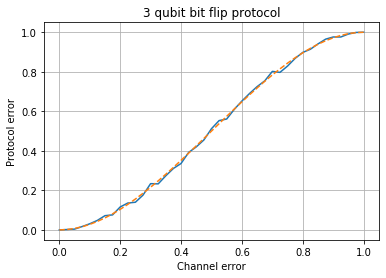

In [139]:
plot_errors(ThreeQubitBitFlipProtocol(), 
            num_experiments=1000, 
            num_points=41, 
            theoretical=lambda x:3*x**2*(1-x)+x**3)

Let's look how cirquit for the whole protocol looks like.

In [52]:
data = {}
test_protocol_once(ThreeQubitBitFlipProtocol(), BitFlipChannel(0.3), output=data)
print(data['circuit'])

aux_1: ────────────────────────────────────X───X───────@───X───X───@───────@───────@───────@───X───@───X───X───@───
                                           │           │       │   │       │       │       │       │       │   │
aux_2: ────────────────────────────────────┼───X───X───@───────@───@───────X───X───@───X───X───────@───────@───@───
                                           │   │       │       │   │       │       │       │       │       │   │
           ┌                           ┐   │   │       │       │   │       │       │       │       │       │   │
q_init: ───│ 0.793+0.j    -0.609+0.j   │───@───@───────X───────@───X───X───@───X───X───X───@───X───X───────@───X───
           │-0.458-0.401j -0.597-0.523j│
           └                           ┘


### Three qubit phase-flip code

Now we have a channel which with probability $p$ changes qubit $a |0>+ b |1>$ to $a|0> - b |1>$ (that is, applies gate Z), and w.p. (1-p) leaves it unchanged.

In [8]:
class PhaseFlipChannel:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob
        
    def transmit(self, ct, q):
        if np.random.rand() < self.flip_prob:
            ct.append(cirq.Z(q))
        return q

Let's see that using three qubit bit flip protocol doesn't give any error correction.

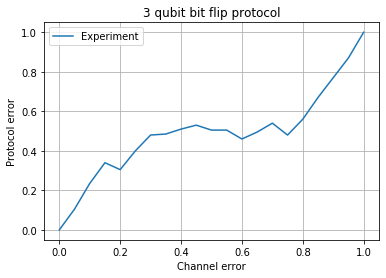

In [13]:
plot_errors(ThreeQubitBitFlipProtocol(), 
            num_points=21, 
            num_experiments=200,
            channel_factory=lambda p:PhaseFlipChannel(p))

Now recall that Z = HXH, and HZH = X. This means that if we put apply Hadamard gate before and after channel, this channel becomes bit-flip channel.

So, we can use the same error-correcting protocol, except we need to apply H gate after encoding and before decoding.

In [17]:
class ThreeQubitPhaseFlipProtocol(BaseQecProtocol):
    def __init__(self):
        self.name = '3 qubit phase flip protocol'
        self.bf_protocol = ThreeQubitBitFlipProtocol()
    
    def encode(self, circuit, qubit):
        qubits = self.bf_protocol.encode(circuit, qubit)
        for q in qubits:
            circuit.append(cirq.H(q))
        return qubits
    
    def decode(self, circuit, qubits):        
        for q in qubits:
            circuit.append(cirq.H(q))
        return self.bf_protocol.decode(circuit, qubits)

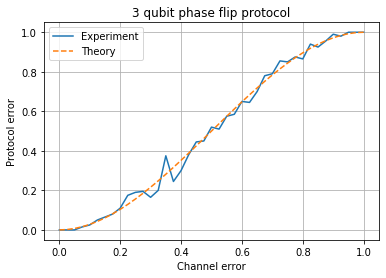

In [19]:
plot_errors(ThreeQubitPhaseFlipProtocol(), 
            num_points=41, 
            num_experiments=200,
            channel_factory=lambda p:PhaseFlipChannel(p),
            theoretical=lambda x:3*x**2*(1-x)+x**3)

### The Shor Code

The Shor code protects from arbitrary errors!

Here we will simulate arbitrary error by applying gates Rx, Ry and Rz with random arguments.

In [35]:
class ArbitraryErrorChannel:
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob
        
    def transmit(self, ct, q):
        if np.random.rand() < self.flip_prob:
            ct.append(cirq.Rx(np.random.rand()*2*np.pi).on(q))
            ct.append(cirq.Ry(np.random.rand()*2*np.pi).on(q))
            ct.append(cirq.Rz(np.random.rand()*2*np.pi).on(q))
        return q

Shor code encodes qubit with 3 qubits using phase shift flip. Then it encodes each of these 3 qubits with bit flip code. Therefore, 9 qubits are transmitted over noisy channel.

In [77]:
class ShorProtocol(BaseQecProtocol):
    def __init__(self):
        self.name = 'Shor Code'
        self.bf_protocol = ThreeQubitBitFlipProtocol()
        self.pf_protocol = ThreeQubitPhaseFlipProtocol()
        
    
    def encode(self, circuit, qubit):
        result = []
        qubits1 = self.pf_protocol.encode(circuit, qubit)
        for q in qubits1:
            result += self.bf_protocol.encode(circuit, q)
        return result
    
    def decode(self, circuit, qubits):        
        return self.pf_protocol.decode(circuit, [
            self.bf_protocol.decode(circuit, qubits[0:3]),
            self.bf_protocol.decode(circuit, qubits[3:6]),
            self.bf_protocol.decode(circuit, qubits[6:9])
        ])
    
test_protocol_once(ShorProtocol(), ArbitraryErrorChannel(0.05))

True

What is error probability of such protocol? It corrects up to 1 errors, and there are 9 qubits being transmitted. No error happens with probability $(1-p)^9$, an one error happens with probability $9p(1-p)^8$. So, error probability is
$1 - (1-p)^9 - 9p(1-p)^8 = 36p^2 + o(p^2)$.



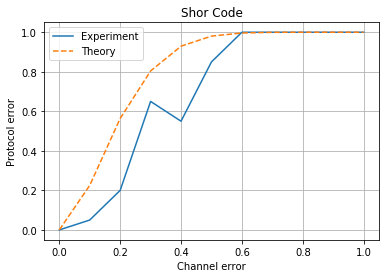

In [81]:
plot_errors(ShorProtocol(), 
            num_points=11, 
            num_experiments=20,
            channel_factory=lambda p:ArbitraryErrorChannel(p),
            theoretical=lambda p:1-(1-p)**9 - 9*p*(1-p)**8)

Let's show that for small error rates of channel this code still gives improvement.

Here as 'Theoretical' we will plot linear function, so while 'Experimental' chart is below it, it is the improvement.

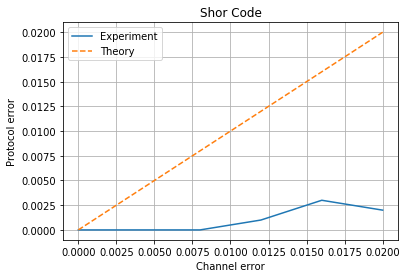

In [100]:
plot_errors(ShorProtocol(), 
            num_points=6, 
            max_p = 0.02,
            num_experiments=1000,
            channel_factory=lambda p:ArbitraryErrorChannel(p),
            theoretical=lambda x:x)

### Recursive bit-flip protocol.

Let's get back to bit-flip protocol and apply ide of Shor code there. Let's encode qubit using bit-flip protocol, and then encode each resulting qubit again. This way we get 9 qubits.

What is the error rate of such protocol (to leading order of $p$, for $p \ll 1$ )? Now at least 4 errors should happen to break protocol, and not any 4 errors will do it. 

Imagine matrix 3x3, in which we write 1 in each cell w.p $p$. Each 1 represents error at qubit transmission. Protocol fails when in at least 2 rows we have at least 2 ones. How many there are different ways to write 4 ones to make it fail?
There are 3 ways to choose 2 rows, and 3 ways to choose 2 cells in each of them, total 3*3*3=27 ways.

So, protocol error rate is $27p^4 + o(p^4)$.

In [94]:
class NineQubitBitFlipProtocol(BaseQecProtocol):
    def __init__(self):
        self.name = '9 qubit bit flip protocol'
        self.bf_protocol_1 = ThreeQubitBitFlipProtocol()
        self.bf_protocol_2 = ThreeQubitBitFlipProtocol()
    
    def encode(self, circuit, qubit):
        result = []
        qubits1 = self.bf_protocol_1.encode(circuit, qubit)
        for q in qubits1:
            result += self.bf_protocol_2.encode(circuit, q)
        return result
    
    def decode(self, circuit, qubits):        
        return self.bf_protocol_1.decode(circuit, [
            self.bf_protocol_2.decode(circuit, qubits[0:3]),
            self.bf_protocol_2.decode(circuit, qubits[3:6]),
            self.bf_protocol_2.decode(circuit, qubits[6:9])
        ])
        
        
test_protocol_once(NineQubitBitFlipProtocol(), BitFlipChannel(0.1))

True

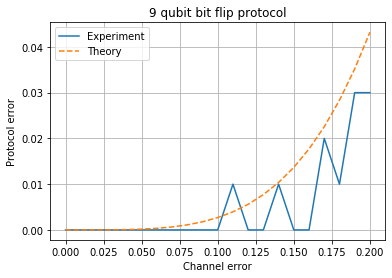

In [99]:
plot_errors(NineQubitBitFlipProtocol(), 
            num_points=21, 
            max_p = 0.2,
            num_experiments=100,
            channel_factory=lambda p:BitFlipChannel(p),
            theoretical=lambda x:27*x**4)

To be continued:
* Calderbank-Shor-Steane codes;
* Stabilizer codes.